# Capstone models

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
import statsmodels as sm
import statsmodels.api as sm

from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv(r"C:\Users\edwar\OneDrive\Documents\Digital Futures\Capstone Project\oahufullandclean.csv")
df

,date,northshore wh,west side wh,southshore wh,diamond head wh,east side wh,wspd,wdir,nsd
0,1990-01-01,5,2,1,1,6,6,3.0,16.0
1,1990-01-02,4,2,1,1,5,5,3.0,2.0
2,1990-01-03,8,4,2,2,5,5,3.0,15.0
3,1990-01-04,5,4,1,2,5,5,3.0,2.0
4,1990-01-05,6,4,1,2,5,6,3.0,16.0
...,...,...,...,...,...,...,...,...,...
11299,2020-12-06,8,4,1,1,2,2,17.0,15.0
11300,2020-12-07,12,7,1,1,2,3,4.0,16.0
11301,2020-12-08,15,8,2,2,2,4,5.0,16.0
11302,2020-12-09,6,3,2,2,2,2,17.0,16.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11304 entries, 0 to 11303
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             11304 non-null  object 
 1   northshore wh    11304 non-null  int64  
 2   west side wh     11304 non-null  int64  
 3   southshore wh    11304 non-null  int64  
 4   diamond head wh  11304 non-null  int64  
 5   east side wh     11304 non-null  int64  
 6   wspd             11304 non-null  int64  
 7   wdir             11304 non-null  float64
 8   nsd              11304 non-null  float64
dtypes: float64(2), int64(6), object(1)
memory usage: 794.9+ KB


## 1) Arima model 

In [7]:
## Create a series 
series = df[['date', 'northshore wh']]
series = series.set_index('date')['northshore wh']
series

date
1990-01-01     5
1990-01-02     4
1990-01-03     8
1990-01-04     5
1990-01-05     6
              ..
2020-12-06     8
2020-12-07    12
2020-12-08    15
2020-12-09     6
2020-12-10     3
Name: northshore wh, Length: 11304, dtype: int64

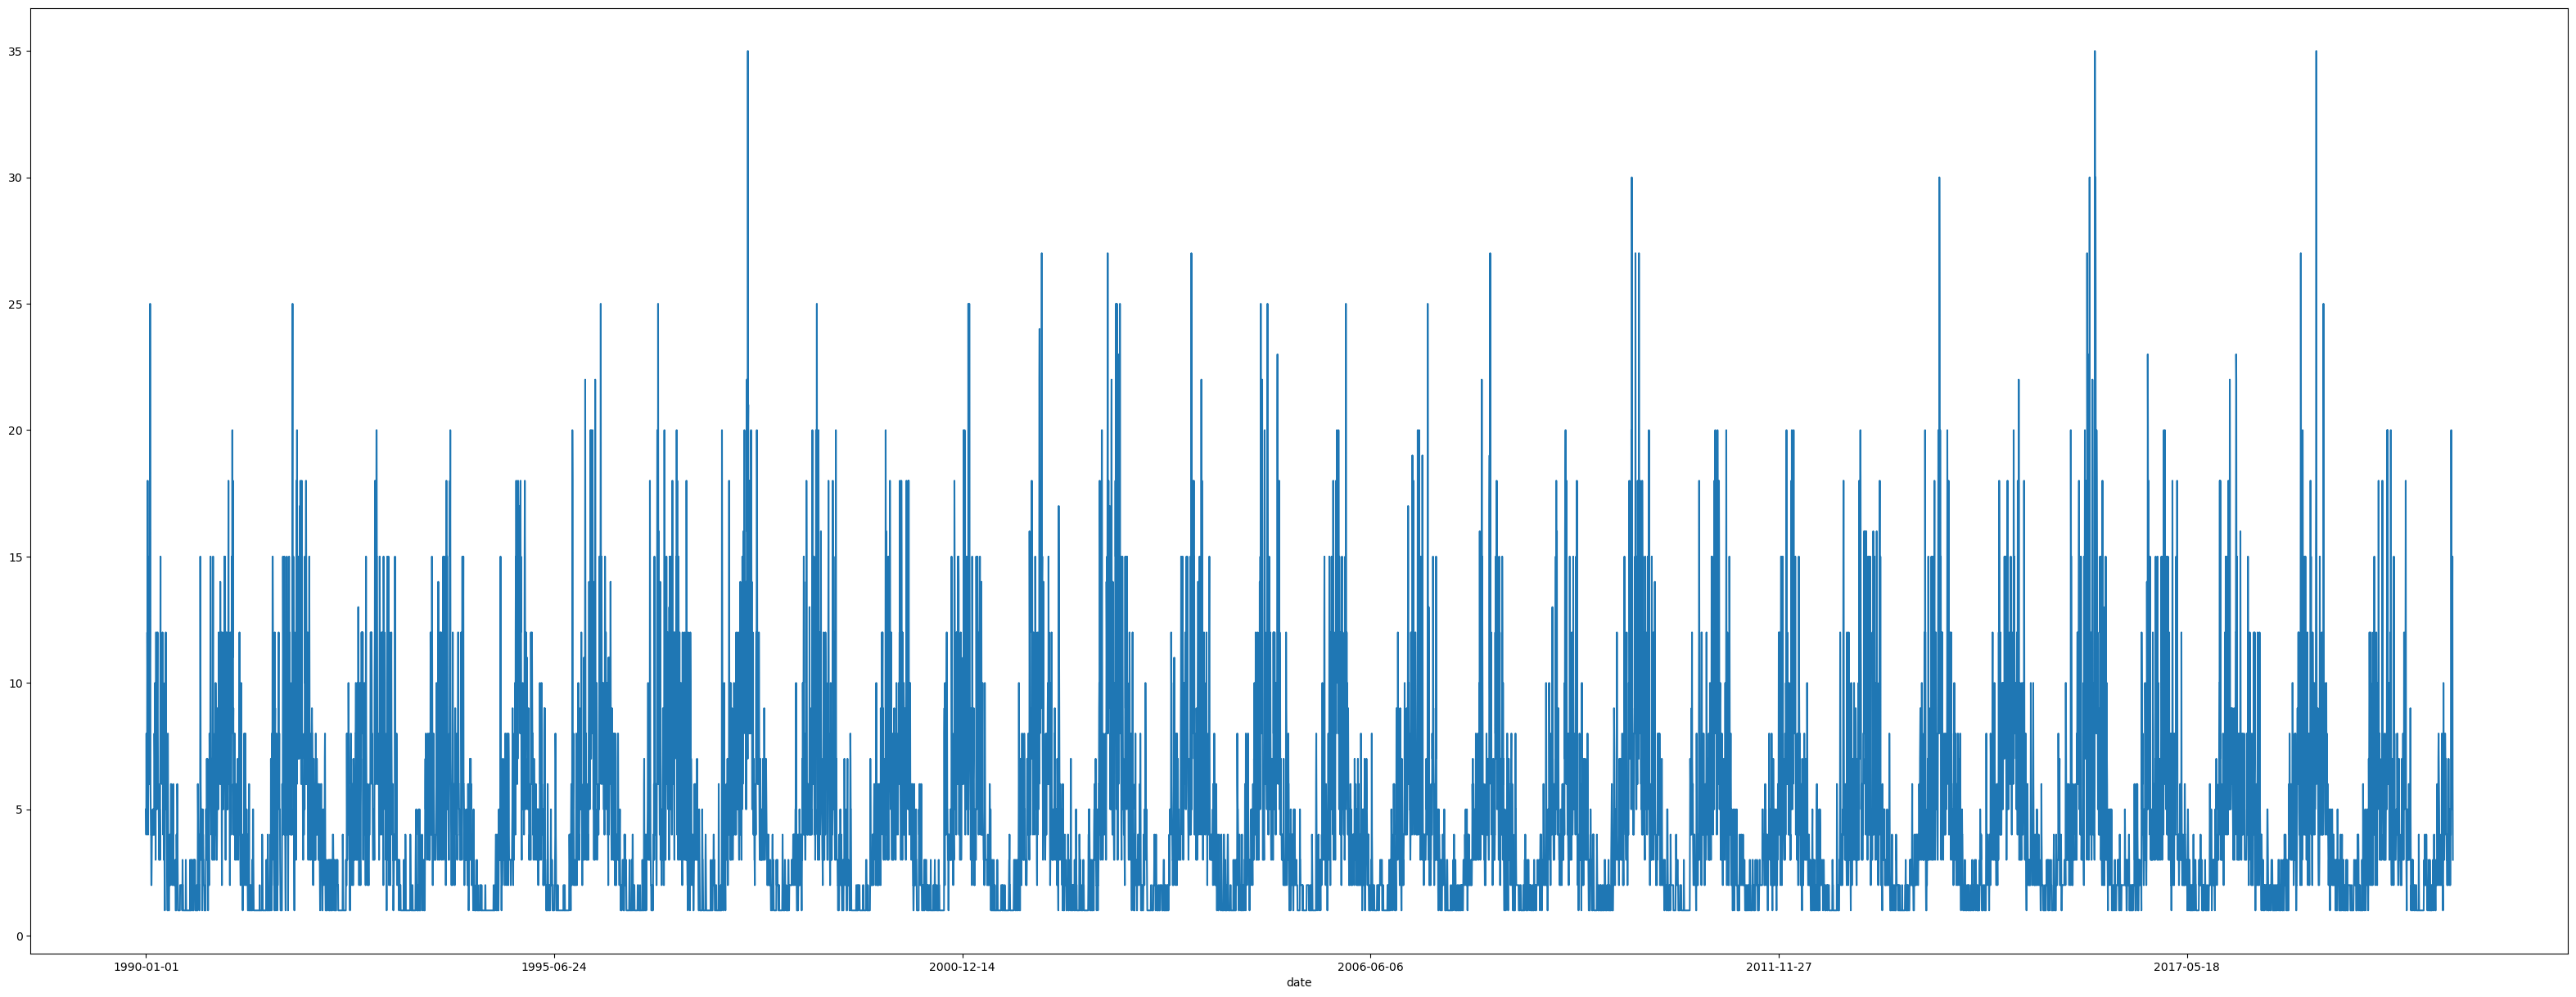

In [8]:
## Plotting Northshore Wave Height Over TIme 
plt.figure(figsize = (40,15))
series.plot()
plt.show()

In [9]:
## Splitting the data into train and test dat es after 2015 = test
split_date = '2020-01-01'
train = series.loc[series.index < split_date].values
test = series.loc[series.index >= split_date].values

In [10]:
## Dickey Fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.827996
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


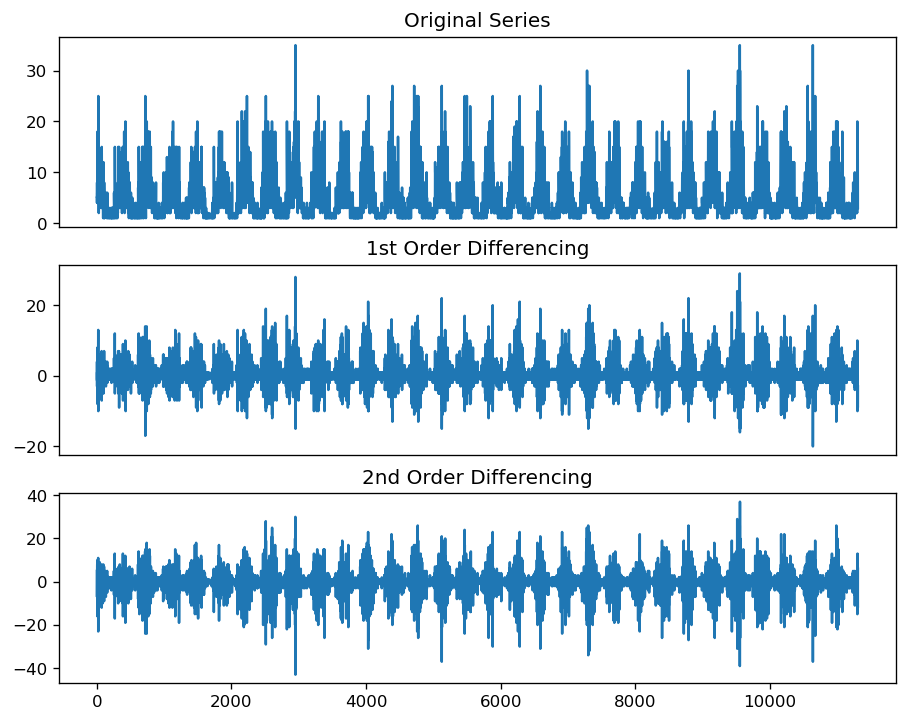

In [11]:
## Differencing 
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(df['northshore wh']); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df['northshore wh'].diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df['northshore wh'].diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

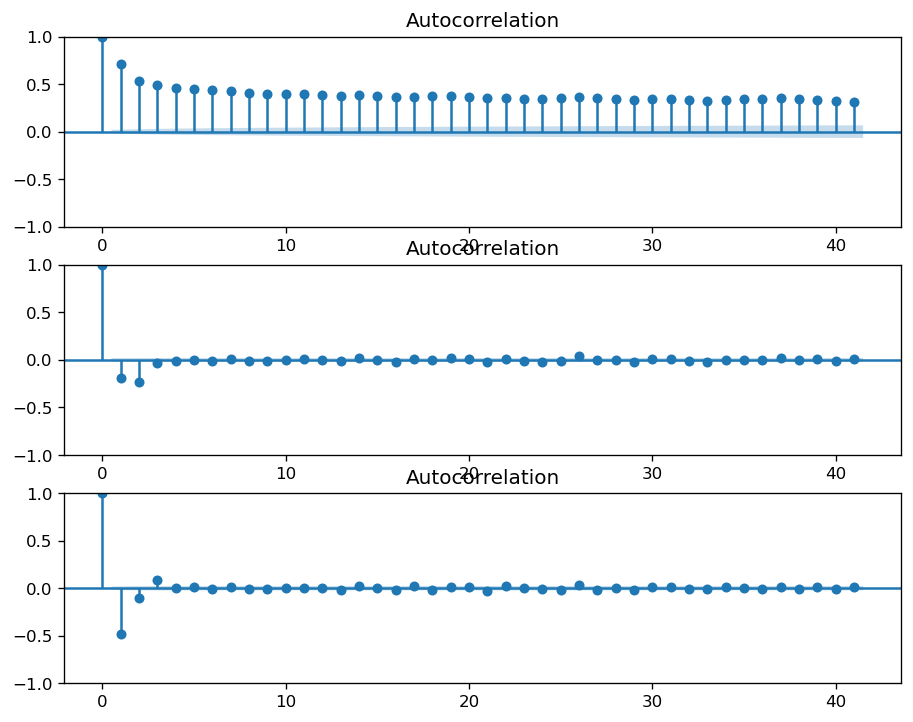

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(df['northshore wh'], ax=ax1)
plot_acf(df['northshore wh'].diff().dropna(), ax=ax2)
plot_acf(df['northshore wh'].diff().diff().dropna(), ax=ax3)
plt.show()

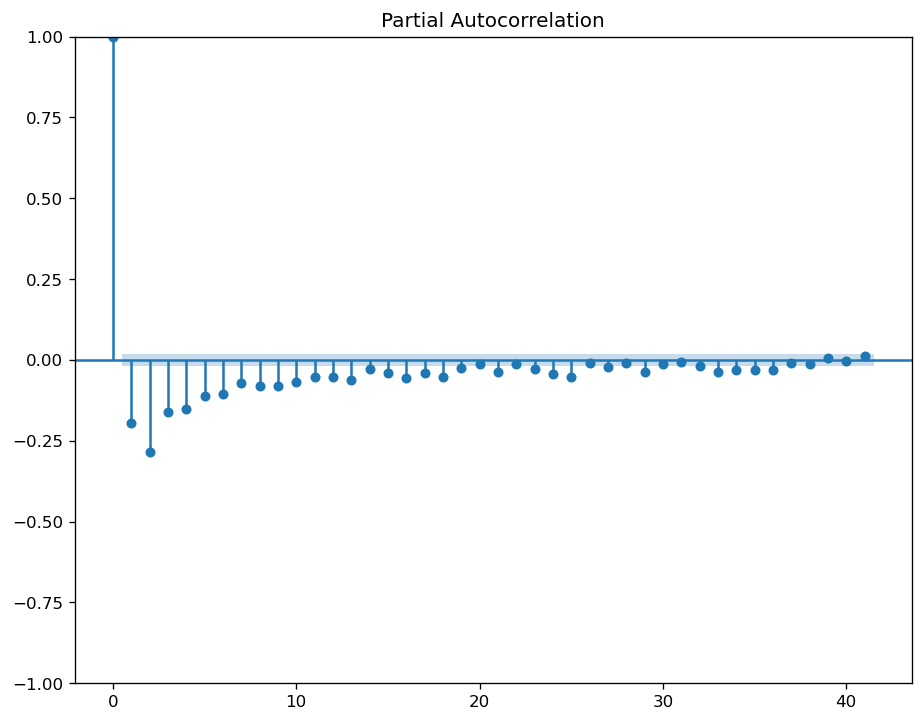

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['northshore wh'].diff().dropna())
plt.show()

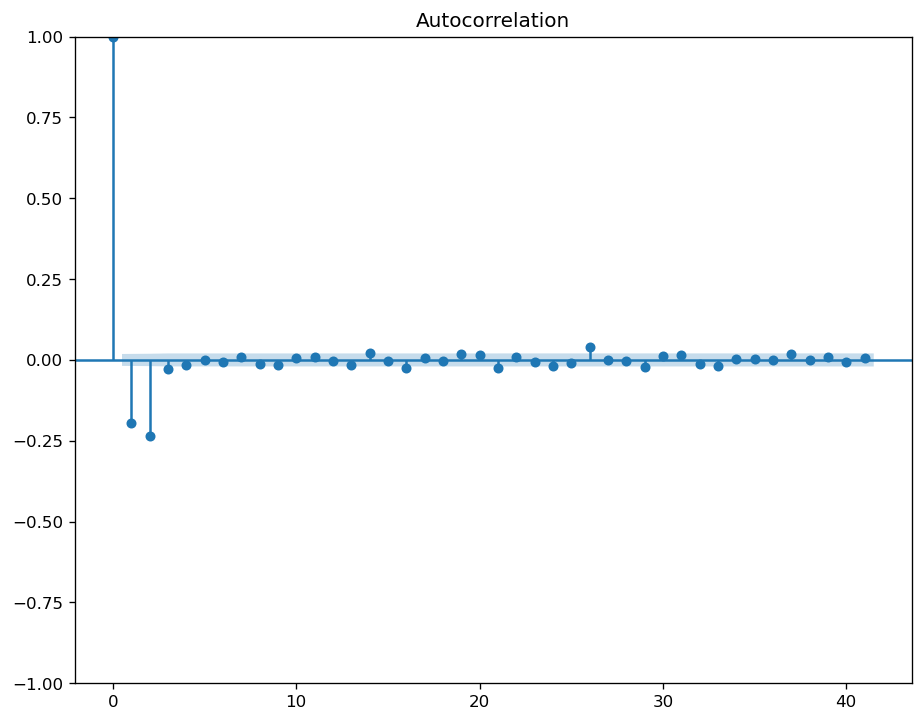

In [14]:
plot_acf(df['northshore wh'].diff().dropna())
plt.show()

In [15]:
## Credit to https://discordapp.com/channels/@me/1194617957624582215/1219956124846133258 for the code here 
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = metrics.mean_squared_error(test, predictions, squared = False)
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

predicted=11.840593, expected=10.000000
predicted=9.555283, expected=6.000000
predicted=8.942558, expected=5.000000
predicted=8.555108, expected=5.000000
predicted=8.310107, expected=5.000000
predicted=8.155144, expected=3.000000
predicted=8.057153, expected=3.000000
predicted=7.995165, expected=3.000000
predicted=7.955992, expected=3.000000
predicted=7.931226, expected=4.000000


KeyboardInterrupt: 

In [ ]:
model = ARIMA(train, seasonal_order = (1,1,3, 365))
model_fit = model.fit()
ouput = model_fit.forecast()

In [ ]:
arimadf = pd.DataFrame(series.loc[series.index >= split_date])

In [ ]:
arimadf['prediction'] = predictions 

In [ ]:
arimadf['date'] = df['date']

In [ ]:
arimadf

In [ ]:
mae = metrics.mean_absolute_error(arimadf['northshore wh'], arimadf['prediction'])
mae

In [ ]:
rmse = metrics.mean_squared_error(arimadf['northshore wh'], arimadf['prediction'], squared=False)
rmse

In [ ]:
mse = metrics.mean_squared_error(arimadf['northshore wh'], arimadf['prediction'], squared = True)
mse

In [ ]:
mape = metrics.mean_absolute_percentage_error(arimadf['northshore wh'], arimadf['prediction'])
mape

In [ ]:
plt.figure(figsize = (15,15))
sns.lineplot(data = arimadf['prediction'])
sns.lineplot(data=arimadf, x='date', y='northshore wh', label='Actual')
sns.lineplot(data=arimadf, x='date', y= 'prediction', label='prediction')
plt.show()

In [ ]:
arimadf.to_csv('arima.csv', index=False)

## 2.0 Linear regression model 

In [ ]:
def speedclean(data):
    data = data.copy()
    data = pd.get_dummies(data, columns = ['wdir'], prefix = 'wdir', drop_first = True, dtype = int)
    data = pd.get_dummies(data, columns = ['nsd'], prefix = 'wdir', drop_first = True, dtype = int)
    data = sm.add_constant(data)
    return data

In [ ]:
dffe = speedclean(df)
dffe

In [ ]:
train = dffe.loc[dffe['date'] < split_date]
test = dffe.loc[dffe['date'] >= split_date]

In [ ]:
def speedclean2(data):
    data = data.copy()
    data['month'] = data['date'].dt.month
    data['day_of_week'] = data['date'].dt.dayofweek
    data = pd.get_dummies(data, columns=['month', 'day_of_week'], drop_first = True, dtype = int)
    data = data.drop('date', axis = 1)
    data = data.drop('diamond head wh', axis = 1)
    return data
    

In [ ]:
train = speedclean2(train)
test = speedclean2(test)

In [ ]:
feature_cols = ['const', 
'west side wh', 
'southshore wh', 
'diamond head wh', 
'east side wh', 
 'wspd', 
 'wdir_2.0',
 'wdir_3.0',
 'wdir_4.0',
 'wdir_5.0',
 'wdir_6.0',
 'wdir_7.0',
 'wdir_8.0',
 'wdir_9.0',
 'wdir_10.0',
 'wdir_11.0',
 'wdir_12.0',
 'wdir_13.0',
 'wdir_14.0',
 'wdir_15.0',
 'wdir_16.0',
 'wdir_17.0',
 'wdir_18.0',
 'wdir_2.0',
 'wdir_3.0',
 'wdir_4.0',
 'wdir_5.0',
 'wdir_10.0',
 'wdir_13.0',
 'wdir_14.0',
 'wdir_15.0',
 'wdir_16.0',
 'wdir_18.0',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'day_of_week_1',
 'day_of_week_2',
 'day_of_week_3',
 'day_of_week_4',
 'day_of_week_5',
 'day_of_week_6']

In [ ]:
X_train = train.drop('northshore wh', axis = 1)
X_train;

In [ ]:
X_test = test.drop('northshore wh', axis = 1)
X_test;

In [ ]:
y_train = train['northshore wh']
y_train;

In [ ]:
y_test = test['northshore wh']
y_test;

In [ ]:
lin_reg = sm.OLS(y_train, X_train) 

In [ ]:
results = lin_reg.fit()

In [ ]:
train['y_train_pred'] = results.predict(X_train)

In [ ]:
mae = metrics.mean_absolute_error(train['northshore wh'], train['y_train_pred'])
print(f'mae = {mae}')
rmse = metrics.mean_squared_error(train['northshore wh'], train['y_train_pred'], squared=False)
print(f'mse = {rmse}')
mse = metrics.mean_squared_error(train['northshore wh'], train['y_train_pred'])
print(f'rmse = {mse}')
mape = metrics.mean_absolute_percentage_error(train['northshore wh'], train['y_train_pred'])
print(f'mape = {mape}')

In [ ]:
test['y_test_pred'] = results.predict(X_test)

In [ ]:
mae = metrics.mean_absolute_error(test['northshore wh'], test['y_test_pred'])
print(f'mae = {mae}')
rmse = metrics.mean_squared_error(test['northshore wh'], test['y_test_pred'], squared=False)
print(f'mse = {rmse}')
mse = metrics.mean_squared_error(test['northshore wh'], test['y_test_pred'])
print(f'rmse = {mse}')
mape = metrics.mean_absolute_percentage_error(test['northshore wh'], test['y_test_pred'])
print(f'mape = {mape}')

In [ ]:
test_results = test[['northshore wh','y_test_pred']]

In [ ]:
test_results['date'] = df.loc[:, 'date']

In [ ]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=test_results, x='date', y='northshore wh', label='Actual')
sns.lineplot(data=test_results, x='date', y='y_test_pred', label='y_test_pred')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

In [ ]:
test_results.to_csv('linreg_results.csv', index=False)